# Unsupervised machine learning techniques

Today we will continue working with the gene expression data of our mice, and try to find patterns in them with the help of unsupervised machine learning algorithms. Unsupervised methods are useful when we have so-called *unlabeled* data: samples with no group membership information, only their raw values.

Of course our expression data isn't unlabeled: we know for every sample 1) what diet it had, 2) what strain it was. But we won't give that information from the upcoming ML methods. We will instead ask these methods to score / separate / cluster the samples based on their raw values only, and then we will verify whether they did it in a way which is consistent with the labels that we had hidden from the algorithms.

The unsupervised techniques we will use today are principal component analysis (PCA), hierarchical clustering and K-means clustering, provided by the feature-rich and easy-to-use `scikit-learn` package. Their website is worth taking a look at for anyone interested in machine learning: it's not just a documentation, but also a great guide for a lot of techniques.

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Task 0: Load the expression data

We will need the original raw expression data (in an unstacked `split_cd_hfd` format), and your differential expression analysis csv. Run the below boxes to make sure we all work on data in the same format.

In [2]:
def split_cd_hfd(input_df):
    input_df.index.name = 'gene'  # change that weird @format=column Excel index label to something meaningful
    input_cd = input_df.filter(regex=r'_CD|CD_') # loc[:, (input_df.columns.str.contains('CD_')) | (input_df.columns.str.contains('_CD'))]
    input_hfd = input_df.filter(regex=r'_HFD|HFD_') #loc[:, (input_df.columns.str.contains('HFD_')) | (input_df.columns.str.contains('_HFD'))]

    input_cd.columns = input_cd.columns.str.replace(r'_CD|CD_', '')
    input_hfd.columns = input_hfd.columns.str.replace(r'_HFD|HFD_', '')
    
    input_cd.insert(0, 'diet', 'CD')
    input_hfd.insert(0, 'diet', 'HFD')
    
    kept_columns = input_cd.columns.intersection(input_hfd.columns)
    
    df_both = pd.concat([input_cd, input_hfd], sort=False)[kept_columns]
    df_both.columns.name = 'strain'  # added only later
    
    return df_both.reset_index().set_index(['gene', 'diet']).sort_index()

In [3]:
xls = pd.read_excel('../example_data/aad0189_DataFileS5.xlsx', header=2)
expr = xls.groupby('Gene.1').mean().filter(regex='Liver')  # or 'Gene' if you had used that for your DE calculations
expr.columns = expr.columns.str.replace('_Liver', '')
expr2 = split_cd_hfd(expr).unstack()

is_hfd = pd.Series((expr2.columns.get_level_values('diet') == 'HFD'), index=expr2.columns)  # diet labels for verification
is_hfd.name = 'is_hfd'

Since `scikit-learn` likes to treat data as one sample per row, we should transpose our expression data matrix, such that rows stand for mice/diet combinations and columns stand for the gene expression values measured by the microarray. Let's call the transposed form of `expr2` as `data`.

In [4]:
data = expr2.T
data

gene             544988  100043387  0610007C21Rik  0610007L01Rik  \
strain   diet                                                      
C57BL/6J CD    6.183000     10.384         12.389        10.2875   
         HFD   6.365333     10.215         12.521        10.3345   
DBA/2J   CD    6.353333      9.848         12.559        10.3900   
         HFD   6.348333     10.153         12.611        10.3630   
BXD43    CD    6.262333     10.108         12.647        10.4110   
...                 ...        ...            ...            ...   
BXD100   HFD   6.331667     10.639         12.550        10.2750   
BXD101   CD    6.432667      9.832         12.661        10.2545   
         HFD   6.216667     10.223         12.660        10.0480   
BXD103   CD    6.428333      9.898         12.583        10.2160   
         HFD   6.278333      9.956         12.696        10.1545   

gene           0610007P08Rik  0610007P14Rik  0610007P22Rik  0610008F07Rik  \
strain   diet                                                               
C57BL/6J CD           8.1160         12.281         8.3640          9.440   
         HFD          8.2415         12.181         8.3720          8.879   
DBA/2J   CD           8.4220         12.305         8.2570          8.576   
         HFD          8.2865         12.326         8.4450          8.574   
BXD43    CD           8.2350         11.949         8.5780          8.264   
...                      ...            ...            ...            ...   
BXD100   HFD          8.1485         12.210         8.3375          8.821   
BXD101   CD           8.1565         12.166         8.2065          9.170   
         HFD          8.1910         11.888         8.3530          8.214   
BXD103   CD           8.1100         12.183         8.4975          8.829   
         HFD          8.2720         12.316         8.5500          8.746   

gene           0610009B14Rik  0610009B22Rik  ...   Zxdc  Zyg11a  Zyg11b  \
strain   diet                                ...                          
C57BL/6J CD            7.033         10.904  ...  9.104   8.152  10.427   
         HFD           7.165         10.866  ...  9.122   7.358  10.259   
DBA/2J   CD            7.126         10.949  ...  9.087   7.754  10.162   
         HFD           7.053         11.028  ...  9.287   7.299  10.304   
BXD43    CD            7.374         11.024  ...  9.330   7.616  10.062   
...                      ...            ...  ...    ...     ...     ...   
BXD100   HFD           7.055         11.070  ...  9.040   7.389  10.366   
BXD101   CD            7.239         10.702  ...  8.963   7.428  10.287   
         HFD           6.971         11.017  ...  9.155   7.654  10.281   
BXD103   CD            7.159         10.921  ...  9.279   6.849  10.055   
         HFD           7.006         10.958  ...  9.420   7.317  10.198   

gene             Zyx  Zzef1    Zzz3      a   l7Rn6  mCG_21548    rp9  
strain   diet                                                         
C57BL/6J CD    9.668  9.903  10.175  6.939   9.885      7.335  9.943  
         HFD   9.706  9.768  10.046  7.144   9.950      7.634  9.811  
DBA/2J   CD    9.411  9.565  10.361  7.398   9.945      7.801  9.795  
         HFD   9.615  9.554  10.106  7.152  10.169      7.720  9.743  
BXD43    CD    9.576  9.650  10.231  7.447  10.123      7.789  9.860  
...              ...    ...     ...    ...     ...        ...    ...  
BXD100   HFD   9.437  9.688  10.090  7.241   9.907      7.821  9.600  
BXD101   CD    9.493  9.674  10.379  7.329   9.765      7.901  9.732  
         HFD   9.638  9.550  10.108  7.226   9.918      7.541  9.746  
BXD103   CD    9.684  9.521  10.207  7.371   9.681      8.034  9.715  
         HFD   9.471  9.433  10.182  7.283   9.748      7.846  9.788  

[78 rows x 21835 columns]

And finally load your differential expression summary `diffexpr` from Day 5 for later use. (log2 fold changes, p-values etc.)

In [5]:
diffexpr = pd.read_csv('../output/diffexpr.csv')
diffexpr['is_de'] = ((diffexpr['mwu pvals corr']<0.01) & (diffexpr['log2fc'].abs()>0.2))
diffexpr

,gene,log2fc,wilcoxon pvals,ttest pvals,mwu pvals,wilcoxon pvals corr,ttest pvals corr,mwu pvals corr,is_de,label
0,544988,-0.041726,0.007690,2.471637e-02,2.461669e-03,0.016986,0.051565,0.007086,False,grey
1,100043387,-0.094410,0.029482,1.105006e-01,1.588075e-01,0.053852,0.179216,0.238169,False,grey
2,0610007C21Rik,-0.011872,0.504683,5.986195e-01,3.684131e-01,0.584529,0.688445,0.468540,False,grey
3,0610007L01Rik,0.007372,0.530015,6.891828e-01,9.561658e-01,0.607698,0.765220,0.971427,False,grey
4,0610007P08Rik,-0.061718,0.030539,6.733311e-02,4.618156e-02,0.055444,0.119326,0.085016,False,grey
...,...,...,...,...,...,...,...,...,...,...
21830,Zzz3,0.153692,0.000002,2.316426e-07,9.252459e-07,0.000021,0.000002,0.000008,False,grey
21831,a,-0.059923,0.121381,1.713445e-01,2.760128e-01,0.178872,0.256500,0.372528,False,grey
21832,l7Rn6,-0.122462,0.000965,8.665480e-03,1.454909e-02,0.002906,0.021283,0.032398,False,grey
21833,mCG_21548,-0.051026,0.204119,1.807908e-01,2.343324e-01,0.277448,0.268068,0.326371,False,grey


## Task 1: Principal component analysis
PCA takes a set of high-dimensional samples (vectors), and transforms them to lower dimensional vectors using a linear transformation. Based on the data, it finds an optimal list of unit length vectors (called principal directions) and projects (or in another interpretation: rotates) the data onto these principal directions with a simple dot product (aka a weighted sum). You can think about these principal directions as feature weight vectors, and the principal component scores as the weighted sums that they produce on your data.

The strength of PCA is in how it chooses these principal directions. The first principal direction is the unit length weight vector that maximizes the variance of the weighted sums when applied on your input vectors. The second principal direction is guaranteed to be orthogonal to the first one (i.e. uncorrelated with it) and also maximizes the variance of the output under this constraint. The third one is orthogonal to both the first and the second... and so on.

Usually the first few principal components *"explain most of the variance"* in your data: the corresponding principal directions have large weights in the dimensions where your data shows a lot of variance, and low weights elsewhere. The orthogonality (uncorrelatedness) of the principal directions guarantees that they capture new sources of variance with each additional step.

Of course PCA is a deep topic and requires a good grasp on linear algebra to understand it in detail, but there are plenty of online resources and textbooks that can help you with that if you're interested. A rough understanding and some hands-on examples can still take us a long way.

### 1.1: Initialize a PCA object with 4 components and transform your data
Browse `scikit-learn`'s documentation to see how. Call the PCA object as `pca_model` and remember not to overwrite it later. Store the resulting principal component values in `pc_values`. You will see that it's a 78x4 numpy matrix, where 78 stands for the number of samples you had, and 4 is the number of principal components that you had calculated for them.

In [6]:
pca_model = PCA(n_components=4).fit(data)
pc_values = pca_model.fit_transform(data)
pc_values.shape

(78, 4)

### 1.2: Plot the principal components against each other

Plotting the first principal component against the second is simple enough with matplotlib's `scatter`, but we can do better and create a scatter plot for each pair using seaborn's `pairplot`. This requires your data to be a `DataFrame`, but you know how to turn a numpy matrix into a DF: just pass it to `pd.DataFrame(...)` and name it as `pc_df`. Include the proper row indices while you're at it.

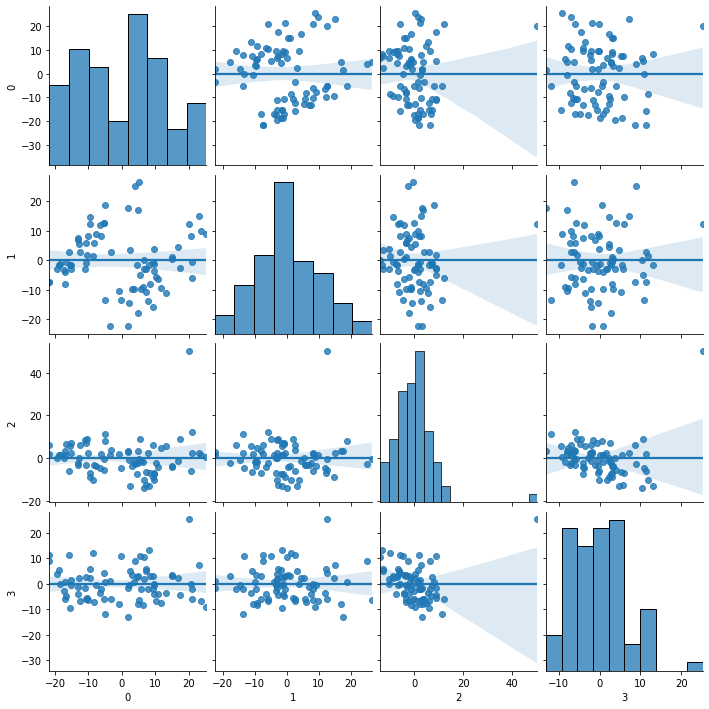

In [7]:
pc_df = pd.DataFrame(pc_values)
sns.pairplot(pc_df, kind='reg')

### 1.2.1: Add color information based on the diet
`sns.pairplot` can color points based on the values of a column specified by `hue` keyword, so add `is_hfd` we had prepared earlier as a new column to `pc_df`. PCA of course did not use the color labels, you only added them afterwards. In light of this, do you find the plots impressive?

- two group seperate well in frist and second principle component, and hard to see in 3, 4 PC, because it eigenvalue is too low to effect.

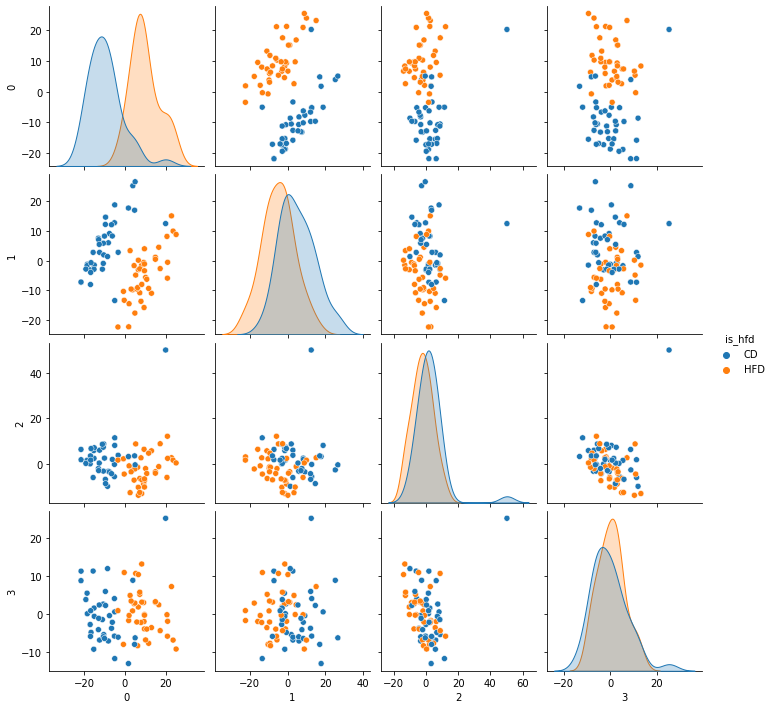

In [8]:
pc_df['is_hfd'] = ['CD' if diet=='CD' else 'HFD' for diet in data.index.get_level_values(level='diet')]
sns.pairplot(pc_df, hue='is_hfd')

### 1.2.2: Optional: repeat the above steps using every 200th gene only. Is the PCA plot still informative?
If you choose to do this task, make sure not to overwrite the original results with all the data. You can keep every 200th gene by creating `data_small = data.iloc[:, ::200]`. We will return to using the full data after this optional subtask.

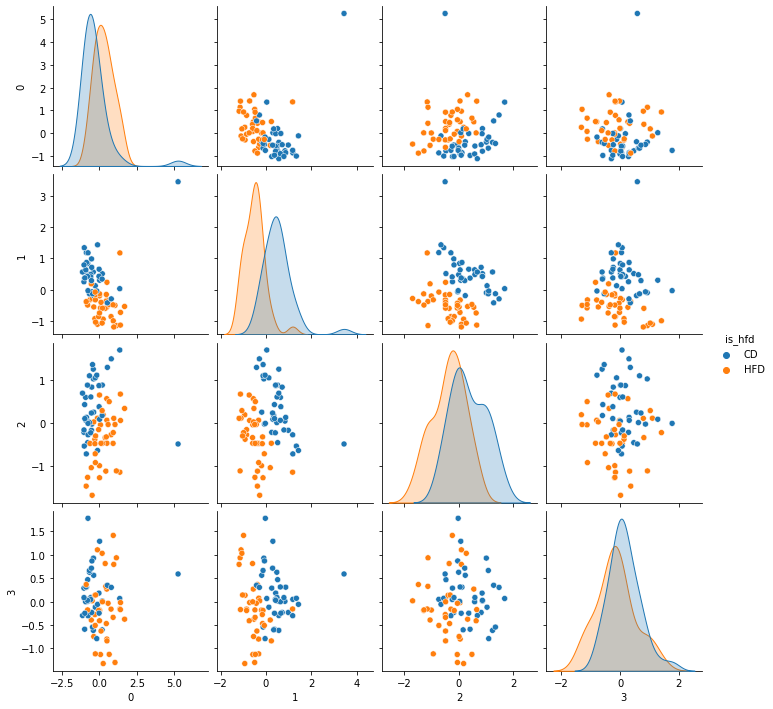

In [9]:
data_small = data.iloc[:, ::200]
test1 = pd.DataFrame(pca_model.fit_transform(data_small))
test1['is_hfd'] = ['CD' if diet=='CD' else 'HFD' for diet in data_small.index.get_level_values(level='diet')]
sns.pairplot(test1, hue='is_hfd')

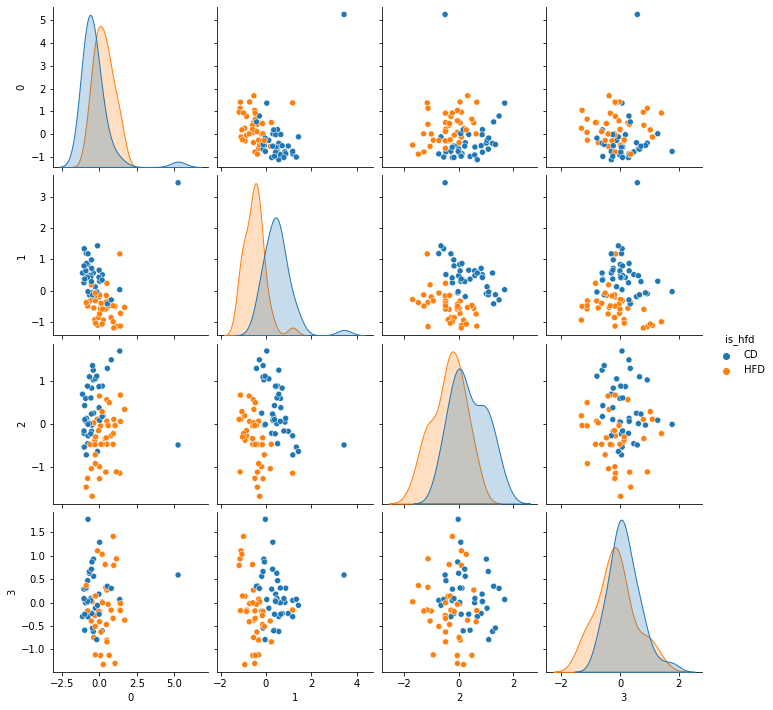

In [10]:
test1 = pca_model.fit_transform(data_small)
test2 = pd.DataFrame(pca_model.fit_transform(test1))
test2['is_hfd'] = ['CD' if diet=='CD' else 'HFD' for diet in data_small.index.get_level_values(level='diet')]
sns.pairplot(test2, hue='is_hfd')

### 1.3: Find the principal directions of the fitted PCA. Are they orthogonal and unit length as promised?
Confusingly, `scikit-learn` (and unfortunately a lot of people as well) like to call the principal directions as "principal components", overloading the term, since it is already used to refer to the transformed values as well. A brief discussion here: https://stats.stackexchange.com/questions/88118/what-exactly-is-called-principal-component-in-pca

Anyway, you will find the principal direction vectors in `pca.components_`. You will see that it's a 21835x4 matrix, where 4 stands for the number of principal directions that you had computed, and 21835 stands for the number of features (genes) in your dataset. Check whether these 21835-dimensional direction vectors are indeed unit length, and whether all pairs of them are orthogonal to each other.

In [11]:
pca_values_21835 = pd.DataFrame(pca_model.components_)
for i in range(pca_values_21835.shape[0]):
    print("unit length in %s: %4f" %(i+1, np.dot(pca_values_21835.loc[i], pca_values_21835.loc[i])))
    for j in range(i, pca_values_21835.shape[0]):
        if i != j:
            print("Orthogonal in (%s, %s): %4f" %(i+1,j+1, np.dot(pca_values_21835.loc[i], pca_values_21835.loc[j])))

unit length in 1: 1.000000
Orthogonal in (1, 2): 0.000000
Orthogonal in (1, 3): 0.000000
Orthogonal in (1, 4): 0.000000
unit length in 2: 1.000000
Orthogonal in (2, 3): 0.000000
Orthogonal in (2, 4): -0.000000
unit length in 3: 1.000000
Orthogonal in (3, 4): 0.000000
unit length in 4: 1.000000


<AxesSubplot:>

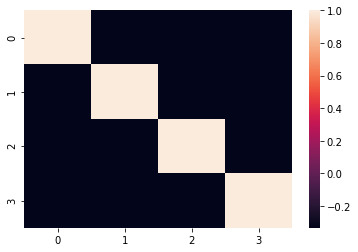

In [12]:
## more easy way to do:
direction_21835 = pca_values_21835.T.corr()
sns.heatmap(direction_21835)

### 1.4: How correlated are the transformed values (principal component scores) with each other? Why is it important?

- in PCA, each eigenvector need to be orthgonal matrix, and each vector also need to be unit length.

<AxesSubplot:>

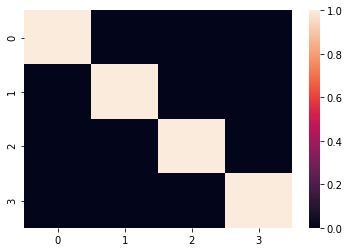

In [13]:
sns.heatmap(pc_df.corr())

### 1.5: Compare the first principal direction's weights with the log-fold-change vector from your differential expression analysis. Visualize them on a scatter plot, and interpret what you see.
Remember, you had computed the fold-change values by comparing expression values between CD and the HFD diets. PCA had no access to the diet information, and yet...

You can also try a scatter plot for weight vs p-values, log10-p, etc. Some of them might look familiar.

Tip: turn the matrix containing the principal direction vectors into a DataFrame called `direction_df`, and add the gene indices. This will make your life easier.

In [14]:
direction_df = pd.DataFrame(pca_model.fit(data).components_.T, index=diffexpr['gene'], columns=['PC1', 'PC2', 'PC3', 'PC4'])
direction_df

,PC1,PC2,PC3,PC4
gene,,,,
544988,0.000910,-0.002160,-0.000957,0.000364
100043387,0.009553,0.010674,-0.000751,-0.007811
0610007C21Rik,-0.000961,-0.003897,0.001735,-0.005499
0610007L01Rik,-0.002442,-0.002914,-0.002741,-0.000005
0610007P08Rik,0.003267,0.003620,-0.006509,0.000124
...,...,...,...,...
Zzz3,-0.003757,0.007541,0.002940,-0.001377
a,-0.001718,-0.010403,0.004131,0.005635
l7Rn6,0.006283,0.005585,-0.010504,0.000224


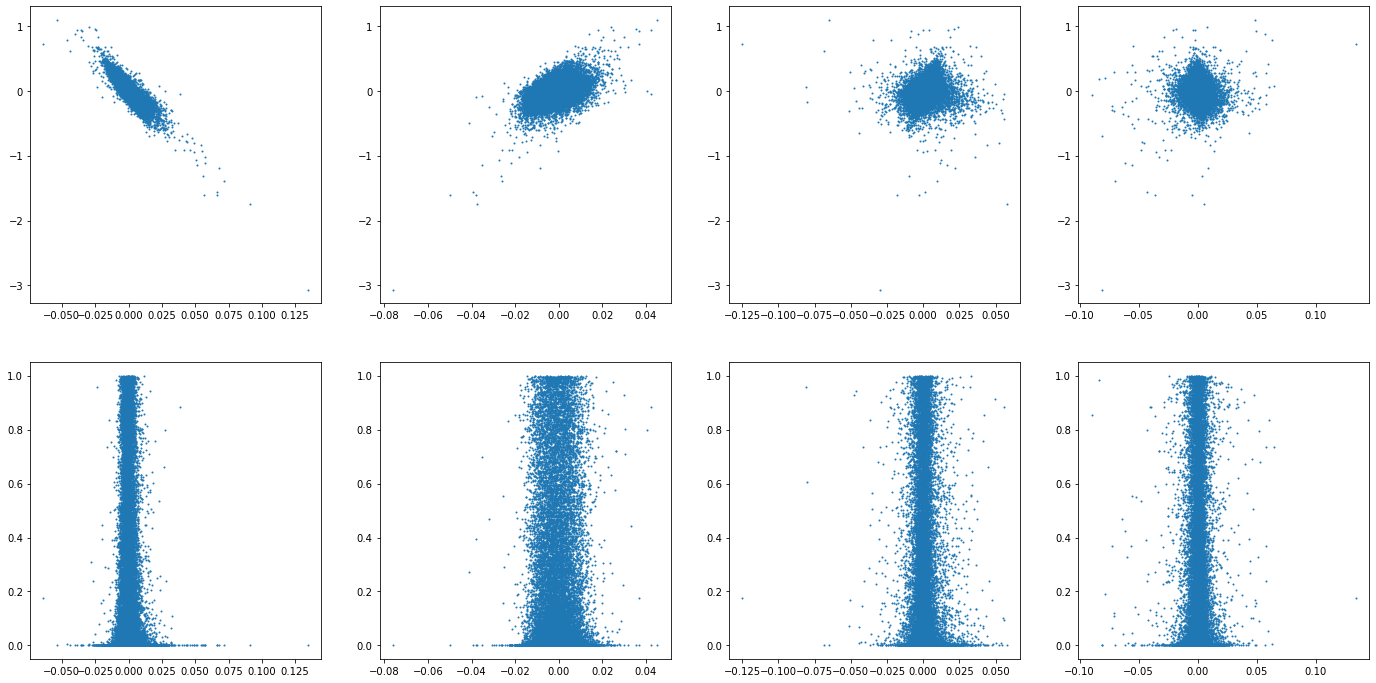

In [15]:
fig, axs = plt.subplots(2,4, figsize=(24,12))
for i, pc in enumerate(direction_df):
    for j, value in enumerate(diffexpr.loc[:,['log2fc','mwu pvals corr']]):
        axs[j,i].scatter(direction_df[pc], diffexpr.loc[:,value], s=1)

In [16]:
pca_model.fit(data).explained_variance_ratio_

array([0.14774729, 0.09669774, 0.06629019, 0.04219442])

### 1.6: Create a scatter plot for PC1 vs PC2 only, but this time connect pairs of points that come from the same strain

Every mouse strain was measured twice, and therefore they each contribute two points to the PCA plot. Connect these pairs of points: it will involve `plt.scatter`, and a `for` loop with `plt.plot` calls.

The pattern of the resulting lines could be interesting. If it is, try to explain why.

(Optional, for those finishing early, or looking for extra tasks: how would you formulate your observation in mathematical terms, and do you see this effect in other principal components?)

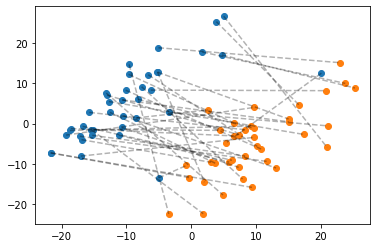

In [17]:
CD = pc_df.loc[pc_df['is_hfd'] == 'CD']
HFD = pc_df.loc[pc_df['is_hfd'] == 'HFD']
plt.scatter(CD[0], CD[1])
plt.scatter(HFD[0], HFD[1])

for cd_point, hfd_point in zip(CD.iterrows(), HFD.iterrows()):
#     print([cd_point[1][0], cd_point[1][1]])
    plt.plot([cd_point[1][0], hfd_point[1][0]], [cd_point[1][1], hfd_point[1][1]], '--k', alpha=0.3)

## Task 2: Hierarchical clustering

You had created cluster-maps before with dendrograms on the top and/or left edges of the figure. They are a result of an unsupervised technique called hierarchical clustering. It iteratively merges single data points into bigger and bigger clusters based on their similarity, one at a time, until all points belong to one big cluster. Seaborn's `clustermap` does it on both axes by default, and produces a heatmap of the values as well.

### 2.1: Create a clustermap
From your first PCA direction vector, take the genes with the 15 largest positive, and 15 largest negative weights, and create a smaller expression matrix with these 30 genes only. Use seaborn's `clustermap` to display a heatmap and a hierarchical clustering of genes and mice. Read on and solve


### 2.2: Display the diet as color labels on the corresponding dendrogram
You will have to convert `is_hfd`'s boolean values to color values first: `y` or `yellow` for `True` and `b` or `blue` for `False` should do fine. Make use of the `.replace` method of Series, and use the dictionary encoding `{True: 'yellow', False: 'blue'}`.

In [18]:
gene_neg = data.loc[:,direction_df['PC1'].sort_values()[0:15].index]
gene_pos = data.loc[:,direction_df['PC1'].sort_values(ascending=False)[0:15].index]
gene = pd.concat([gene_pos, gene_neg], axis=1)
colors = ['blue' if diet=='CD' else 'orange' for diet in gene.index.get_level_values(level='diet')]
gene

gene           Cyp2b9    Lcn2  Cidea    Saa2  Cyp2b13  AB056442  Lgals1  \
strain   diet                                                             
C57BL/6J CD     6.908  13.766  6.495  14.087    5.299     5.579  11.024   
         HFD   13.335  12.335  8.040  11.264    7.549     8.124  12.352   
DBA/2J   CD     6.637   8.521  6.405   8.531    5.460     6.368   9.575   
         HFD    8.067  12.561  7.324  12.381    5.405     6.377   9.571   
BXD43    CD     6.672   9.705  6.507   9.270    5.133     5.646   9.416   
...               ...     ...    ...     ...      ...       ...     ...   
BXD100   HFD   13.793  10.816  7.710  10.907    8.152     7.681  11.377   
BXD101   CD     7.934   8.943  6.459   9.273    5.506     5.598   9.553   
         HFD   12.134  12.591  9.567  11.570    6.839     7.471  11.935   
BXD103   CD     7.436   9.431  6.426   9.649    5.240     5.848   9.932   
         HFD    9.570  10.927  7.252  10.411    6.245     7.673  10.602   

gene             Cd36  D630002G06Rik  9030619P08Rik  ...  Srgap3  Agxt2l1  \
strain   diet                                        ...                    
C57BL/6J CD    10.116          6.502          9.732  ...  8.2065   11.288   
         HFD   11.876          8.191         10.774  ...  7.0910   10.926   
DBA/2J   CD     9.549          6.806          8.810  ...  8.4410   11.388   
         HFD   10.691          7.962          9.636  ...  7.6180   10.425   
BXD43    CD    10.135          6.352          7.735  ...  7.8515   12.873   
...               ...            ...            ...  ...     ...      ...   
BXD100   HFD   12.177          8.933          9.954  ...  7.3755   11.089   
BXD101   CD    10.469          6.616          8.215  ...  8.3835   12.376   
         HFD   12.674          8.170          9.612  ...  7.2190   11.244   
BXD103   CD    10.093          6.691          8.439  ...  8.6150   11.496   
         HFD   11.431          8.434          9.127  ...  7.6550   10.978   

gene             Csad  Gpr110    Ces6  Gm15441  V165-D-J-Cmu  Cyp4a12b  \
strain   diet                                                            
C57BL/6J CD    11.565   9.841  11.429    6.749         6.794    13.275   
         HFD   10.530   7.352  10.153    6.735         6.098    12.543   
DBA/2J   CD    11.799   9.165  11.179    7.144         6.729    13.948   
         HFD   10.321   8.283  10.268    6.151         5.871    13.896   
BXD43    CD    11.185   9.222  10.797   10.665         6.616    13.982   
...               ...     ...     ...      ...           ...       ...   
BXD100   HFD   10.622   6.788  10.277    6.433         6.016    13.149   
BXD101   CD    11.355   9.065  11.136    7.010         6.654    13.562   
         HFD   10.660   6.979   9.732    7.552         5.852    13.370   
BXD103   CD    11.902   7.283  10.836    7.246         6.724    13.597   
         HFD   11.056   6.940  10.159    6.917         5.616    13.405   

gene            Hamp2   Grm8  
strain   diet                 
C57BL/6J CD     8.859  7.790  
         HFD    9.508  6.674  
DBA/2J   CD    10.969  7.328  
         HFD    9.979  6.951  
BXD43    CD    10.380  7.512  
...               ...    ...  
BXD100   HFD   11.319  6.827  
BXD101   CD     9.404  8.066  
         HFD    9.179  6.703  
BXD103   CD    12.620  7.041  
         HFD   10.965  6.344  

[78 rows x 30 columns]

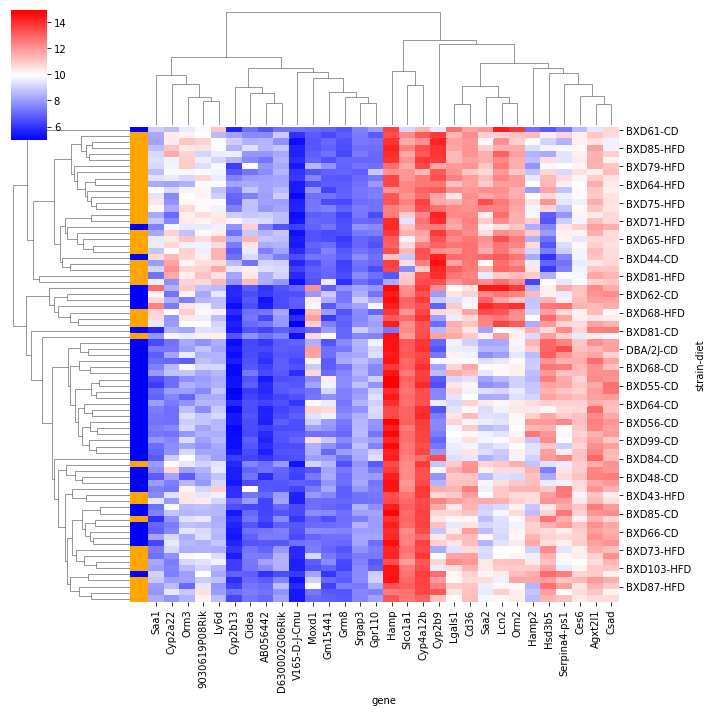

In [19]:
sns.clustermap(gene, row_colors=colors, cmap='bwr')

### 2.3: Standardize the matrix
Like we saw yesterday, it is hard to see the fine differences between the gene expression levels across mice, because the range of general expression levels across genes is much higher. To circumvent this, we standardize our data: for every gene, subtract the mean and optionally divide by the standard deviation.

You can do this with yesterday's pandas one-liner, or as a clustermap keyword setting, or with sklearn's `StandardScaler` tool. You can simply extend Task 2.2 in the above cell with this and overwrite the previous clustermap.

### 2.4: Try different linkage methods
The linkage method changes the definition of cluster similarities. For example, `single` defines the distance of two clusters as the smallest distance of any two elements between them. Its opposite is `complete` which takes the largest distance of any two elements between the two clusters. Between these two extremes are `centroid`, `average`, and a few more. Look at how they affect the topology of the clusters. Which one seems most suitable in our case?

- method of average is better, because it cause less miss grouping of diet.

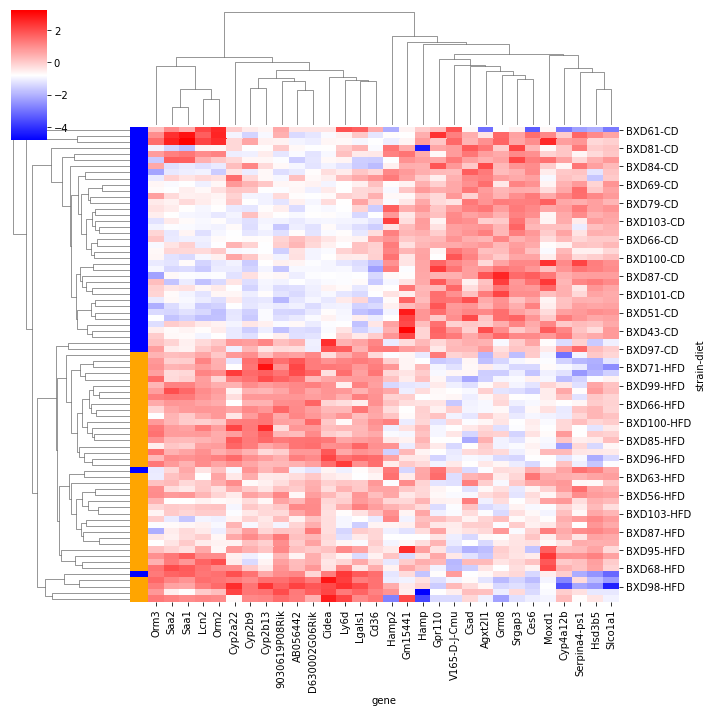

In [20]:
gene = gene.subtract(gene.mean(axis=0), axis=1)
gene = gene.divide(gene.std(axis=0), axis=1)
sns.clustermap(gene, row_colors=colors, cmap='bwr')

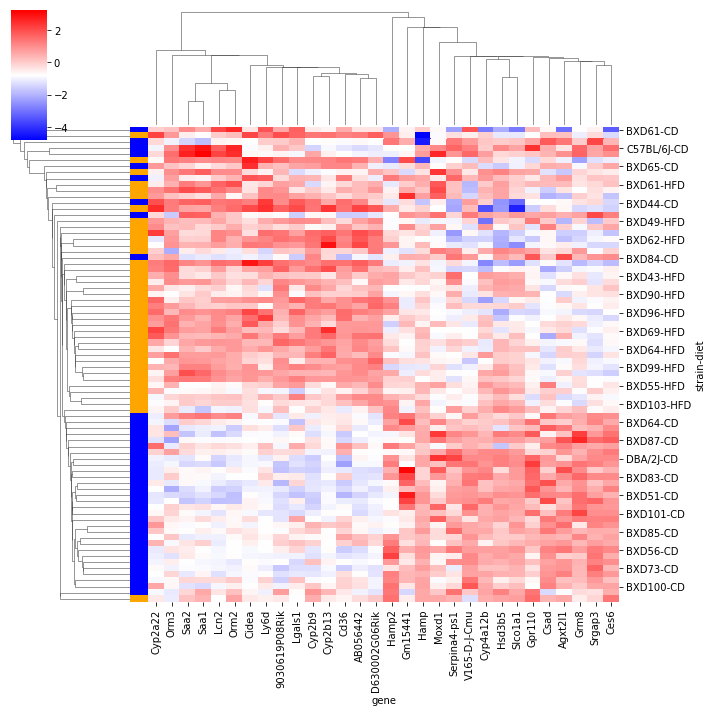

In [21]:
sns.clustermap(gene, row_colors=colors, cmap='bwr', method='single')

## Task 3: K-means clustering

K-means clustering attempts to create `k` virtual samples, whose average distances to the nearest actual samples is as small as possible. These `k` virtual samples are called cluster centers/prototypes or centroids. Each sample is assigned to the nearest centroid, therefore partitioning the samples to k clusters.

### 3.1: Perform k-means clustering on the expression dataset. What k would be the natural choice?

In [22]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(data)

### 3.2: Compare the resulting clusters with the diet labels
Tip: remember `crosstab`? You can concatenate the cluster labels with the diet information and cross-tabulate them. Interpret the results i

Optional: try higher k-values, and investigate the resulting clusters.

In [23]:
kmeans_df = pd.DataFrame(kmeans.fit_predict(data), index=is_hfd.index)
kmeans_df

0
strain   diet   
C57BL/6J CD    1
         HFD   0
DBA/2J   CD    1
         HFD   0
BXD43    CD    1
...           ..
BXD100   HFD   0
BXD101   CD    1
         HFD   0
BXD103   CD    1
         HFD   0

[78 rows x 1 columns]

In [24]:
kmean_merge = pd.concat([is_hfd, kmeans_df], axis=1)
kmean_merge.columns = ['is_hfd', 'cluster']

count_table = pd.crosstab(kmean_merge.iloc[:,0]==True, kmean_merge.iloc[:,1]==1)
count_table

cluster,False,True
is_hfd,,
False,1,38
True,39,0


### 3.3: With k=2, take the centroids, and transform them with the same `pca_model` that you had trained earlier. Highlight them on the PC1 vs PC2 plot.

The cluster centers are virutal samples, which means they pretty much look like real data measured on real mice: they are a bunch of expression values. Of course they aren't real measurements, more like "representatives" of the K clusters. You can treat them as if they were proper samples, and therefore you can transform them re-using the PCA model from Task 1.1. This time you should use `.transform` instead of `.fit_transform` because you don't want to change the original model, only apply it to this new data.

Before doing this, think about where you would expect them to fall. Did they?

In [25]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(data)
pc_kmean = pca_model.transform(kmeans.cluster_centers_)

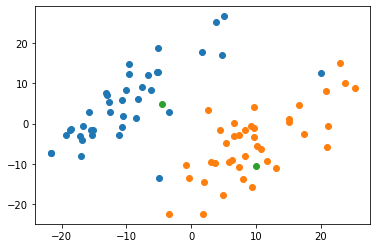

In [26]:
CD = pc_df.loc[pc_df['is_hfd'] == 'CD']
HFD = pc_df.loc[pc_df['is_hfd'] == 'HFD']
plt.scatter(CD[0], CD[1])
plt.scatter(HFD[0], HFD[1])
plt.scatter(pc_kmean[0][0:2], pc_kmean[1][0:2])

### 3.4: Train a 2-means clustering model on half of the samples and predict cluster membership on the other half of the samples
Since the CD and HFD samples are alternating rows of our, you can just use `data.iloc[:len(data)//2]` for the training and `data.iloc[len(data)//2:]` for the prediction to split them evenly. What do you find?

In [28]:
train = data.iloc[:len(data)//2]
test = data.iloc[len(data)//2:]

kmeans.fit(train)

pred = kmeans.predict(test)

pd.crosstab(pred, is_hfd.loc[test.index])

is_hfd,False,True
row_0,,
0,0,20
1,19,0
